In [8]:
# imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms.functional as TF


(512, 512)
0.003921569 0.9882353
float32


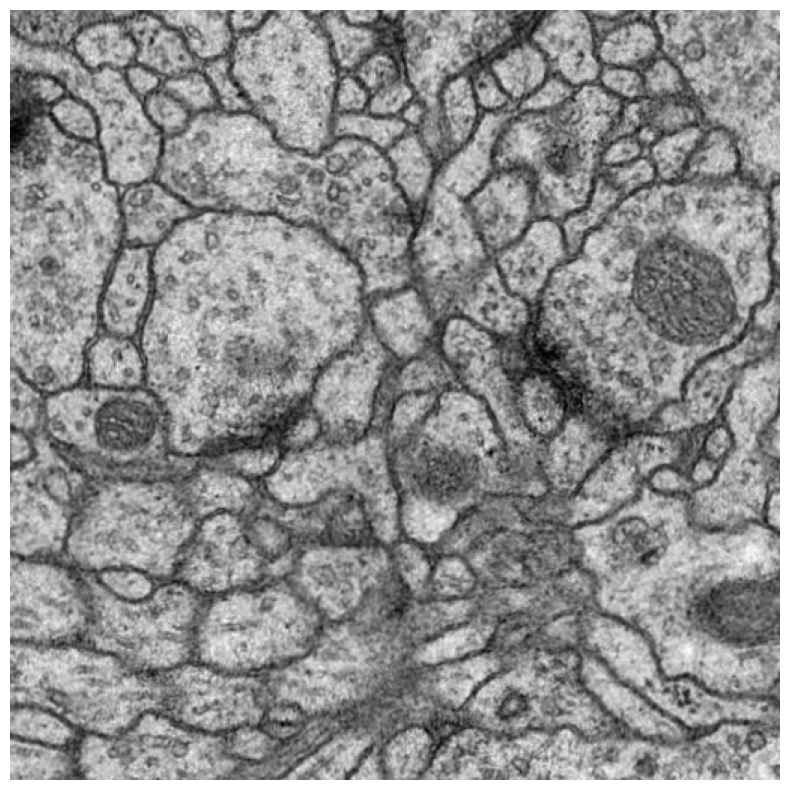

In [9]:
folder = 'data/train_images/'

# read train_images
def read_train_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # normalize the image to [0, 1]
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return images

images = read_train_images(folder)

# show the first image
print(images[0].shape)
print(images[0].min(),images[0].max())
print(images[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

(512, 512)
0.0 1.0
float32


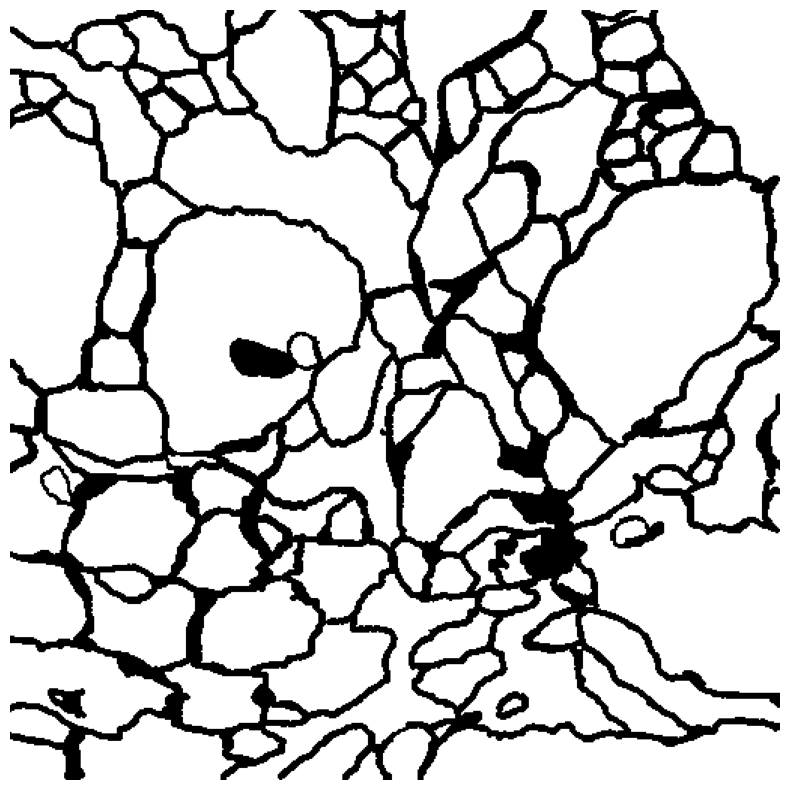

In [10]:
folder = 'data/train_labels/'

labels = read_train_images(folder)

# show the first image
print(labels[0].shape)
print(labels[0].min(),labels[0].max())
print(labels[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap = 'gray')
plt.axis('off')
plt.show()

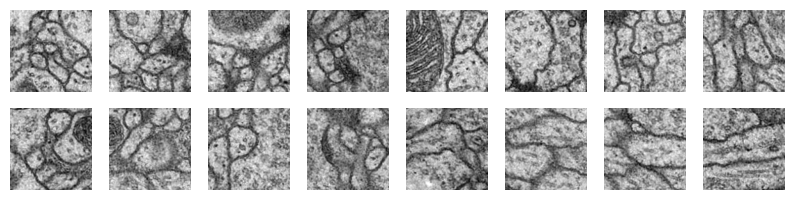

In [11]:
# do patches of the images, of 128x128
def create_patches(images, patch_size=128):
    patches = []
    for image in images:
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
    
    return patches

# create patches of the first image
patches_images = create_patches(images, patch_size=128)

patches_images_ex = patches_images[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_images_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

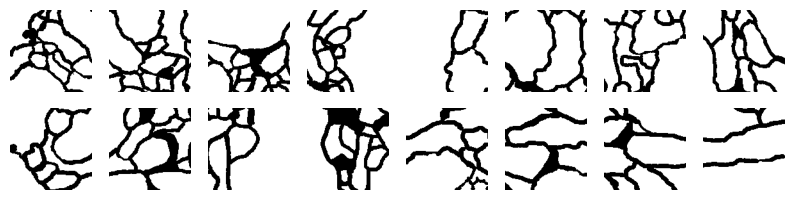

In [12]:
# create patches of the first image
patches_labels = create_patches(labels, patch_size=128)

patches_labels_ex = patches_labels[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_labels_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

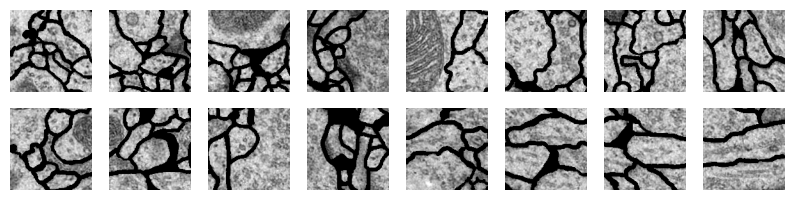

In [13]:
# show the images and above the labels use patches_images and patches_labels
plt.figure(figsize=(10, 10))
for i in range(0, 16):
    plt.subplot(8, 8, i+1)
    #plt.imshow(patches_images[i], cmap='gray')
    plt.imshow(patches_images_ex[i]*patches_labels_ex[i], cmap='gray')
    plt.axis('off')
plt.show()


In [24]:
# test set
folder = 'data/test_images/'
# read test_images
test_images = read_train_images(folder)
patches_test_images = create_patches(test_images, patch_size=128)


In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # grayscale: in_channels=1
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))  # for binary segmentation

'''
# Example
model = UNet(in_channels=1, out_channels=1)
#x = torch.randn(1, 1, 128, 128)  # grayscale image
x = patches_images[0]  # use the first patch
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
y = model(x)
print(y.shape)  # should be [1, 1, 128, 128]
'''

'\n# Example\nmodel = UNet(in_channels=1, out_channels=1)\n#x = torch.randn(1, 1, 128, 128)  # grayscale image\nx = patches_images[0]  # use the first patch\nx = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions\ny = model(x)\nprint(y.shape)  # should be [1, 1, 128, 128]\n'

In [17]:
class JointTransform:
    def __init__(self, hflip=True, vflip=True, rotation=True):
        self.hflip = hflip
        self.vflip = vflip
        self.rotation = rotation

    def __call__(self, image, label):
        # Random horizontal flip
        if self.hflip and random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)
        
        # Random vertical flip
        if self.vflip and random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

        # Random rotation (0, 90, 180, or 270 degrees)
        if self.rotation:
            angles = [0, 90, 180, 270]
            angle = random.choice(angles)
            image = TF.rotate(image, angle)
            label = TF.rotate(label, angle)

        return image, label

In [25]:
class PatchDataset(Dataset):
    def __init__(self, image_patches, label_patches=None, transform=None):
        self.image_patches = image_patches
        self.label_patches = label_patches
        self.transform = transform

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = self.image_patches[idx]
        label = self.label_patches[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [30]:
# maybe convert your patches to tensors first if they are still numpy arrays
image_patches = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_images]
label_patches = [torch.tensor(lbl, dtype=torch.float32).unsqueeze(0) for lbl in patches_labels]
image_patches_test = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_test_images]
print(len(image_patches), len(label_patches), len(image_patches_test))
transform = JointTransform()

augmented_images = []
augmented_labels = []

# Apply 3 augmentations per original image
for img, lbl in zip(image_patches, label_patches):
    for _ in range(3):
        img_aug, lbl_aug = transform(img, lbl)
        augmented_images.append(img_aug)
        augmented_labels.append(lbl_aug)

# Combine original and augmented
all_images = image_patches + augmented_images
all_labels = label_patches + augmented_labels

print(len(all_images), len(all_labels))

480 480 480
1920 1920


In [28]:

X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.25, random_state=42)

# Create datasets
train_dataset = PatchDataset(X_train, y_train)
val_dataset = PatchDataset(X_val, y_val)
test_set = PatchDataset(image_patches_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Check the length of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_set)}")

Train dataset size: 1440
Validation dataset size: 480
Test dataset size: 480


In [22]:
# Define model
model = UNet(in_channels=1, out_channels=1)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Define loss and opti
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

Using device: cpu


In [23]:
# Metrics
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def iou_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

In [ ]:
# Create a train one epoch function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    num_batches = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Pixel accuracy
        preds_bin = outputs > 0.5
        correct_pixels += (preds_bin == labels.bool()).sum().item()
        total_pixels += torch.numel(labels)

        # Dice & IoU
        total_dice += dice_coeff(outputs, labels)
        total_iou += iou_coeff(outputs, labels)

        num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches

    return epoch_loss, pixel_acc, avg_dice, avg_iou

In [13]:
# create a validate one epoch function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Pixel accuracy
            preds_bin = outputs > 0.5
            correct_pixels += (preds_bin == labels.bool()).sum().item()
            total_pixels += torch.numel(labels)

            # Dice & IoU
            total_dice += dice_coeff(outputs, labels)
            total_iou += iou_coeff(outputs, labels)

            num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    
    return epoch_loss, pixel_acc, avg_dice, avg_iou

In [14]:
# Make training and val loop
num_epochs = 10
train_accs = []
train_dices = []
train_ious = []

val_accs = []
val_dices = []
val_ious = []

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou = train_one_epoch(model, train_loader, criterion=loss_fn, optimizer=optimizer, device=device)
    val_loss, val_acc, val_dice, val_iou = validate(model, val_loader, criterion=loss_fn, device=device)

    train_accs.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)

    val_accs.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)

    print(f"Epoch {epoch+1}/{num_epochs}:\nTrain acc: {train_acc:.4f}\nTrain loss: {train_loss:.4f}\nVal acc: {val_acc:.4f}\nVal loss: {val_loss:.4f}")
    print("-" * 50)

Epoch 1/10:
Train acc: 0.7509
Train loss: 0.4982
Val acc: 0.7688
Val loss: 0.4171
--------------------------------------------------
Epoch 2/10:
Train acc: 0.8110
Train loss: 0.3595
Val acc: 0.7951
Val loss: 0.3766
--------------------------------------------------
Epoch 3/10:
Train acc: 0.8326
Train loss: 0.3366
Val acc: 0.8439
Val loss: 0.3337
--------------------------------------------------
Epoch 4/10:
Train acc: 0.8419
Train loss: 0.3237
Val acc: 0.8447
Val loss: 0.3211
--------------------------------------------------
Epoch 5/10:
Train acc: 0.8538
Train loss: 0.3044
Val acc: 0.8555
Val loss: 0.3055
--------------------------------------------------
Epoch 6/10:
Train acc: 0.8582
Train loss: 0.3475
Val acc: 0.8496
Val loss: 0.3157
--------------------------------------------------
Epoch 7/10:
Train acc: 0.8608
Train loss: 0.3006
Val acc: 0.8646
Val loss: 0.2937
--------------------------------------------------
Epoch 8/10:
Train acc: 0.8322
Train loss: 0.3406
Val acc: 0.8526
Val 

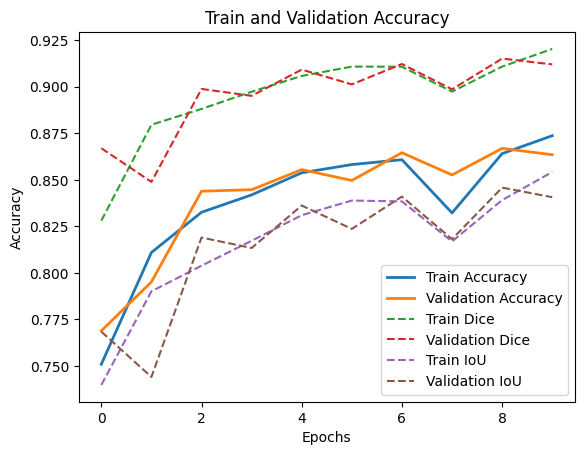

In [20]:
# plot the train and val loss
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.plot(train_dices, label='Train Dice', linestyle='--')
plt.plot(val_dices, label='Validation Dice', linestyle='--')
plt.plot(train_ious, label='Train IoU', linestyle='--')
plt.plot(val_ious, label='Validation IoU', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [16]:
# Test
test_loss, test_acc, test_dice, test_iou = validate(model, test_loader, criterion=loss_fn, device=device)
print(f"Test acc: {test_acc:.4f}\nTest loss: {test_loss:.4f}")

Test acc: 0.8737
Test loss: 0.2800
